# CMA-MAE and Archive Thresholds

**This tutorial assumes that you understand the CMA-ME algorithm.** 

If you are not familiar with CMA-ME, we recommend reading through and playing around with the following tutorials on CMA-ME:
- [Using CMA-ME to Land a Lunar Lander Like a Space Shuttle](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html)
- [Illuminating the Latent Space of an MNIST GAN](https://docs.pyribs.org/en/latest/tutorials/lsi_mnist.html)

## Setup

Firstly, let's import some utility libraries that we will use later.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

Secondly, let's define **the sphere function and its gradients**.

It is not important to understand the implementation of this method, but it is important to understand how this particular sphere function differs from the standard [sphere function](https://en.wikipedia.org/wiki/Sphere).

The particular sphere function used in this example is adapted from Section 4 of [Fontaine 2020](https://arxiv.org/abs/1912.02400). Namely, each solution value is clipped to the range $[-5.12, 5.12]$, and the optimum is moved from $[0,..]$ to $[0.4 \times 5.12 = 2.048,..]$. Furthermore, the objectives are normalized to the range $[0,100]$ where $100$ is the maximum and corresponds to $0$ on the original sphere function.

There are two measures in this example. The first is the sum of the first $\frac{n}{2}$ clipped values of the solution, and the second is the sum of the last $\frac{n}{2}$ clipped values of the solution. Having each measure depend equally on several values in the solution space makes the problem more difficult (refer to [Fontaine 2020](https://arxiv.org/abs/1912.02400) for more information).

In [2]:
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
        solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
        objective_batch (np.ndarray): (batch_size,) batch of objectives.
        measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Compute gradient of the objective
    objective_grad_batch = -2 * (solution_batch - sphere_shift)

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_indices = np.where(np.logical_or(clipped > 5.12, clipped < -5.12))
    clipped[clip_indices] = 5.12 / clipped[clip_indices]
    measures_batch = np.concatenate(
        (
            np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
            np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
        ),
        axis=1,
    )

    # Compute gradient of the measures
    derivatives = np.ones(solution_batch.shape)
    derivatives[clip_indices] = -5.12 / np.square(solution_batch[clip_indices])

    mask_0 = np.concatenate((np.ones(dim // 2), np.zeros(dim - dim // 2)))
    mask_1 = np.concatenate((np.zeros(dim // 2), np.ones(dim - dim // 2)))

    d_measure0 = derivatives * mask_0
    d_measure1 = derivatives * mask_1

    measures_grad_batch = np.stack((d_measure0, d_measure1), axis=1)

    return (
        objective_batch,
        objective_grad_batch,
        measures_batch,
        measures_grad_batch,
    )

## CMA-MAE with pyribs

TODO: Overview of CMA-MAE

<!-- Think about being > vs >= to the threshold — e.g. if someone sets the min objective to be 0.0 and thus sets threshold_min to be 0.0, they would expect an entry into the archive with objective 0.0 to make it in, but it currently would not — perhaps we can just tell people to set threshold min to some slightly smaller value -->

We will create an `GridArchive` using the following parameters. In particular, we use a learning rate of 0.01 and minimum threshold of 0.

In [25]:
from ribs.archives import GridArchive

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

Since solutions are added to the archive based on the cell's **threshold** rather than the cell's **objective**, it is possible for CMA-MAE to make backwards progress. Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current occupant, which results in overwriting the **better** solution.

TODO: Add concrete example with numbers

For this reason, CMA-MAE requires a separate **result archive** that keeps track of the best solutions encountered in each cell. Fortunately, this exactly the default behavior of `GridArchive`, with `learning_rate = 0` and `threashold_min=-inf`.

In [26]:
result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

CMA-MAE is based on CMA-ME. The original conception of CMA-MAE uses $15$ `EvolutionStrategyEmitter` as defined in the following cell.

> We strongly encourage you to play around with the parameters of this emitter (i.e. `x0`, `sigma0`, `ranker`, `selection_rule`, `restart_rule`, and `batch_size`), or experiment with different combination of emitters (such as mixing different emitters together). The setup that we are using might not be optimal!

In [27]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

Finally, we can define the `Scheduler` with the additional parameter of `result_archive`. The `Scheduler` class will be responsible for interacting with the `result_archive` so that it keeps track of the best solutions.

In [28]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Running the CMA-MAE

Now we can finally run CMA-MAE!

We will run it for 10000 iterations following the experiment in (TODO cite matt).

In [29]:
itrs = 10_000

for itr in trange(1, itrs + 1):
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Logging and output every 500 iteration or on final iteration.
    if itr % 500 == 0 or itr == itrs:
        # Record and display metrics.
        print(f"Iteration {itr} | Archive Coverage: "
              f"{result_archive.stats.coverage * 100:.3f}% "
              f"QD Score: {result_archive.stats.qd_score:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 500 | Archive Coverage: 53.980% QD Score: 441678.192
Iteration 1000 | Archive Coverage: 64.250% QD Score: 506982.603
Iteration 1500 | Archive Coverage: 71.430% QD Score: 545695.051
Iteration 2000 | Archive Coverage: 74.790% QD Score: 570044.154
Iteration 2500 | Archive Coverage: 76.830% QD Score: 585600.776
Iteration 3000 | Archive Coverage: 77.470% QD Score: 593205.355
Iteration 3500 | Archive Coverage: 78.010% QD Score: 599972.898
Iteration 4000 | Archive Coverage: 78.650% QD Score: 607343.336
Iteration 4500 | Archive Coverage: 78.890% QD Score: 610967.827
Iteration 5000 | Archive Coverage: 79.430% QD Score: 615528.338
Iteration 5500 | Archive Coverage: 79.740% QD Score: 618522.133
Iteration 6000 | Archive Coverage: 79.890% QD Score: 620668.277
Iteration 6500 | Archive Coverage: 80.000% QD Score: 622475.265
Iteration 7000 | Archive Coverage: 80.150% QD Score: 624751.679
Iteration 7500 | Archive Coverage: 80.190% QD Score: 625928.192
Iteration 8000 | Archive Coverage: 80.230

## Visualization

As usual, we will visualize the archive using `grid_archive_heatmap`

Text(0.5, 36.72222222222221, 'X')

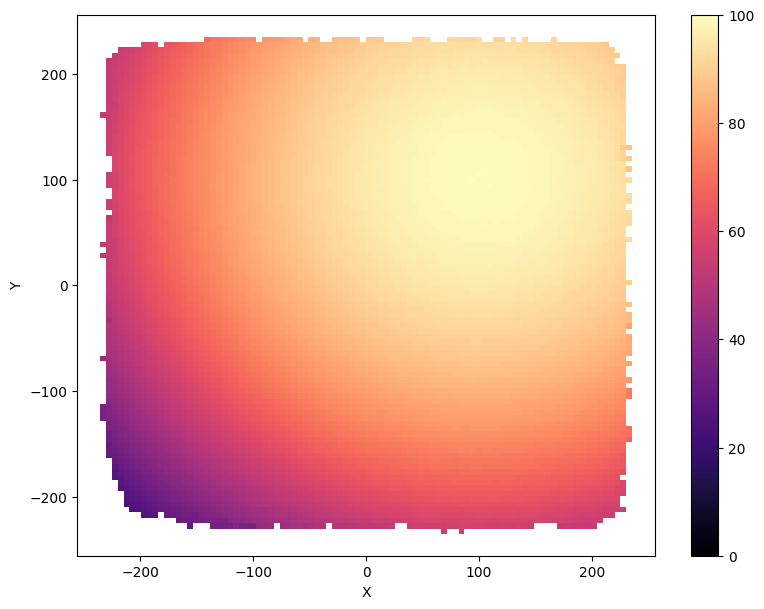

In [32]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")

# Extension: CMA-MAEGA with pyribs

CMA-MAEGA, proposed in the same paper as CMA-MAE, combines the archive thresholds with the `GradientArborescenceEmitter`.

If you want to see this algorithm in action, you can run the following cell to set up the scheduler.

In [21]:
from ribs.archives import GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive_mega = GridArchive(solution_dim=solution_dim,
                           dims=archive_dims,
                           ranges=bounds,
                           learning_rate=learning_rate,
                           threshold_min=0)

result_archive_mega = GridArchive(solution_dim=solution_dim,
                                  dims=archive_dims,
                                  ranges=bounds)

emitters_mega = [
    GradientArborescenceEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=10.0,
        step_size=1.0,
        ranker="imp",
        grad_opt="gradient_ascent",
        restart_rule="basic",
        bounds=None,
        batch_size=36,
    ) for _ in range(15)
]

scheduler_mega = Scheduler(archive_mega, emitters_mega, result_archive=result_archive_mega)

And the following cell to run the algorithm.

In [22]:
itrs = 4500

for itr in trange(1, itrs + 1):
    # DQD ask-tell.
    solution_batch = scheduler_mega.ask_dqd()

    (objective_batch, objective_grad_batch, measures_batch, measures_grad_batch) = sphere(solution_batch)

    objective_grad_batch = np.expand_dims(objective_grad_batch, axis=1)
    jacobian_batch = np.concatenate((objective_grad_batch, measures_grad_batch), axis=1)
    scheduler_mega.tell_dqd(objective_batch, measures_batch, jacobian_batch)

    # ask-tell
    solution_batch = scheduler_mega.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler_mega.tell(objective_batch, measure_batch)

    # Logging and output every 500 iteration or on final iteration.
    if itr % 500 == 0 or itr == itrs:
        # Record and display metrics.
        print(f"Iteration {itr} | Archive Coverage: "
              f"{result_archive_mega.stats.coverage * 100:.3f}% "
              f"QD Score: {result_archive_mega.stats.qd_score:.3f}")

  0%|          | 0/4500 [00:00<?, ?it/s]

Iteration 500 | Archive Coverage: 95.330% QD Score: 718919.393
Iteration 1000 | Archive Coverage: 99.050% QD Score: 749825.597
Iteration 1500 | Archive Coverage: 99.720% QD Score: 752198.192
Iteration 2000 | Archive Coverage: 99.960% QD Score: 753062.133
Iteration 2500 | Archive Coverage: 100.000% QD Score: 753319.934
Iteration 3000 | Archive Coverage: 100.000% QD Score: 753420.704
Iteration 3500 | Archive Coverage: 100.000% QD Score: 753492.928
Iteration 4000 | Archive Coverage: 100.000% QD Score: 753558.983
Iteration 4500 | Archive Coverage: 100.000% QD Score: 753600.769


Notice that the CMA-MEGA fully explores the archive around 2000 iterations, which is way better than CMA-MAE. It also beats the QD score of CMA-MAE.

Now, let's visualize the result archive.

Text(0.5, 36.72222222222221, 'X')

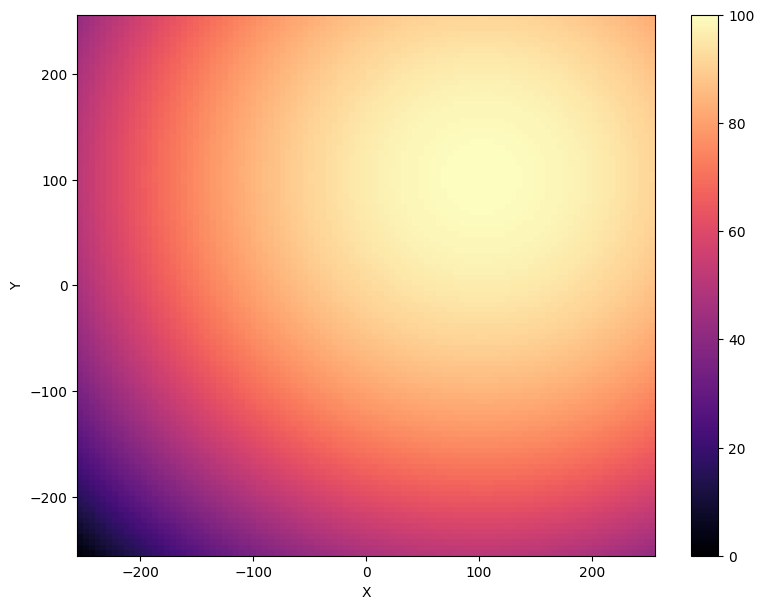

In [24]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive_mega, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")